In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
# import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

# ### Functions used in this code
# import age_functions as afunc

## Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

###
import linearfitting as linfit
import geometry as geo

import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
#######################
### Import SMC Data ###
#######################

#total number 1225
smc = fits.getdata('/Users/joshpovick/Desktop/Research/SMC_Gradients/smc_rgbmembers.r13-l33-58932beta.fits.gz') 

cln = np.where((smc['FE_H']>-9999.0)&(smc['AK_TARG']>-9999.0)&(smc['LOGG']>0.0)&
               (smc['FE_H_ERR']>-90.0)&(smc['C_FE']>-9999.0)&(smc['N_FE']>-9999.0))

#total number 990
smc = smc[cln]

In [267]:
####################################
### Gaia Query Using Online Form ###
####################################

# (00:52:44, −72:49:42) Used in SMASH
center = SkyCoord('00:52:44 -72:49:42', unit=(u.hourangle, u.deg))

print('''Cone search center: {} with radius 6.5 deg'''.format(center))

smc_gaia = fits.getdata('smc_apogee-result.fits.gz')
cln = np.where((smc_gaia['astrometric_excess_noise']<1.0)&(np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&(np.isfinite(smc_gaia['phot_bp_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_rp_mean_mag'])==True)&(smc_gaia['parallax']<0.2)&
               (smc_gaia['parallax']>-0.2))
smc_gaia = smc_gaia[cln]

Cone search center: <SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)> with radius 6.5 deg


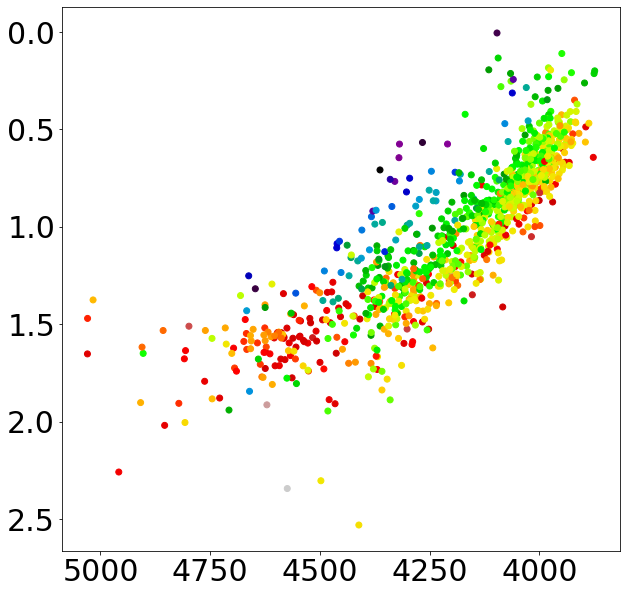

In [330]:
plt.figure(figsize=[10,10])
plt.scatter(smc['TEFF'],smc['LOGG'],c=smc['FE_H'],cmap='nipy_spectral')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [6]:
np.where(np.isfinite(smc_gaia['radial_velocity'])==True)

(array([   4586,    5482,    6858, ..., 2867272, 2870616, 2873546]),)

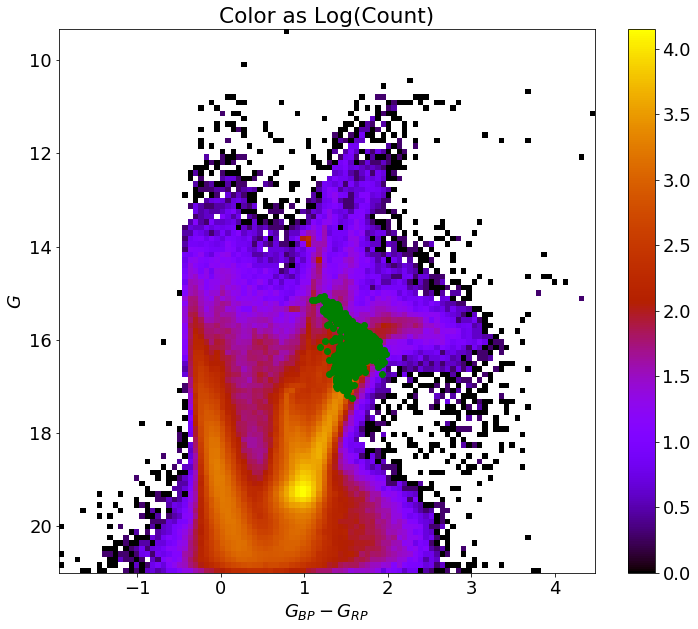

In [268]:
from scipy.stats import binned_statistic_2d
N = binned_statistic_2d(x=smc_gaia['bp_rp'],y=smc_gaia['phot_g_mean_mag'],
                        values=smc_gaia['bp_rp'],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(N.statistic.T),origin='lower',
           extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

plt.scatter(smc['GAIA_BPMAG']-smc['GAIA_RPMAG'],smc['GAIA_GMAG'],c='green')

plt.gca().invert_yaxis()

plt.title(r'Color as Log(Count)')
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'$G$')

plt.savefig('CMDWithGaia.pdf',bbox_inches='tight')

plt.show()

In [269]:
# rc_cut = np.where((smc_gaia['bp_rp']<1.1)&()&()&())


# from photutils import centroid_com

# centr = centroid_com(np.log10(N.statistic.T)[70:90,40:60])
# np.round(centr)

# centr = np.nanmean(N.statistic.T,0)
# np.round(centr)

# x_cen = np.linspace(np.min(smc_gaia['bp_rp']),np.max(smc_gaia['bp_rp']),100)[int(round(centr[0]))]
# y_cen = np.linspace(np.min(smc_gaia['phot_g_mean_mag']),
#                     np.max(smc_gaia['phot_g_mean_mag']),100)[int(round(centr[1]))]

# print('x centroid: ',x_cen)
# print('y centroid: ',y_cen)

In [270]:
rc_cut = np.where((smc_gaia['bp_rp']>0.65)&(smc_gaia['bp_rp']<1.25)&(smc_gaia['phot_g_mean_mag']>18.8)
                  &(smc_gaia['phot_g_mean_mag']<19.7))
rc_gaia = smc_gaia[rc_cut]

In [271]:
np.where(np.isfinite(rc_gaia['radial_velocity'])==True)

(array([], dtype=int64),)

In [272]:
np.mean(rc_gaia['phot_g_mean_mag'])

19.213259

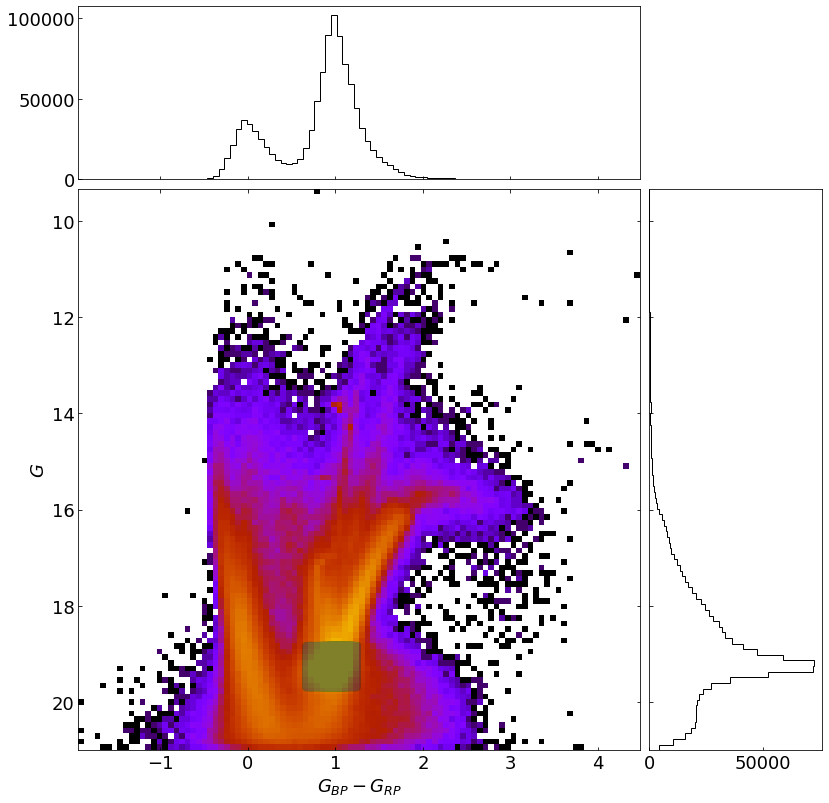

In [273]:
# x=smc_gaia['bp_rp']
# y=smc_gaia['phot_g_mean_mag']

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.011

rect_image = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(12, 12))

ax_image = plt.axes(rect_image)
ax_image.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False) 

# the image plot:
ax_image.imshow(np.log10(N.statistic.T),origin='lower',
           extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
# ax_image.scatter(0.96,19.275,marker='*')
ax_image.scatter(rc_gaia['bp_rp'],rc_gaia['phot_g_mean_mag'],alpha=0.01,c='gray')
ax_image.invert_yaxis()
ax_image.set_xlabel(r'$G_{BP} - G_{RP}$')
ax_image.set_ylabel(r'$G$')

bins = 100
ax_histx.hist(smc_gaia['bp_rp'], bins=bins,histtype='step',color='k')
ax_histy.hist(smc_gaia['phot_g_mean_mag'], bins=bins,histtype='step',orientation='horizontal',color='k')
ax_histy.invert_yaxis()

ax_histx.set_xlim(ax_image.get_xlim())
ax_histy.set_ylim(ax_image.get_ylim())

plt.show()

In [93]:
smc_gaia.columns

ColDefs(
    name = 'solution_id'; format = 'K'
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'
    name = 'random_index'; format = 'K'
    name = 'ref_epoch'; format = 'D'; unit = 'yr'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = 'mas'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = 'mas'
    name = 'parallax'; format = 'D'; unit = 'mas'
    name = 'parallax_error'; format = 'D'; unit = 'mas'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmra_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra_corr'; format = 'E'
    name = 'ra_pmdec_corr'; format = 'E'
    name = 'dec_parallax_corr'; format = 'E'
    na

Text(0, 0.5, '$G$')

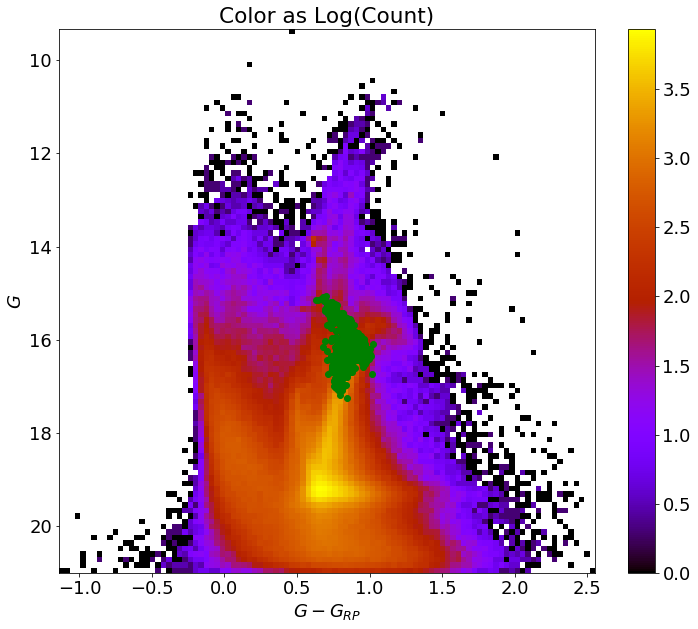

In [274]:
Nggrp = binned_statistic_2d(x=smc_gaia['g_rp'],y=smc_gaia['phot_g_mean_mag'],
                            values=smc_gaia['g_rp'],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Nggrp.statistic.T),origin='lower',
           extent=[Nggrp.x_edge[0],Nggrp.x_edge[-1],Nggrp.y_edge[0],Nggrp.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

plt.scatter(smc['GAIA_GMAG']-smc['GAIA_RPMAG'],smc['GAIA_GMAG'],c='green')

plt.gca().invert_yaxis()

plt.title(r'Color as Log(Count)')
plt.xlabel(r'$G - G_{RP}$')
plt.ylabel(r'$G$')

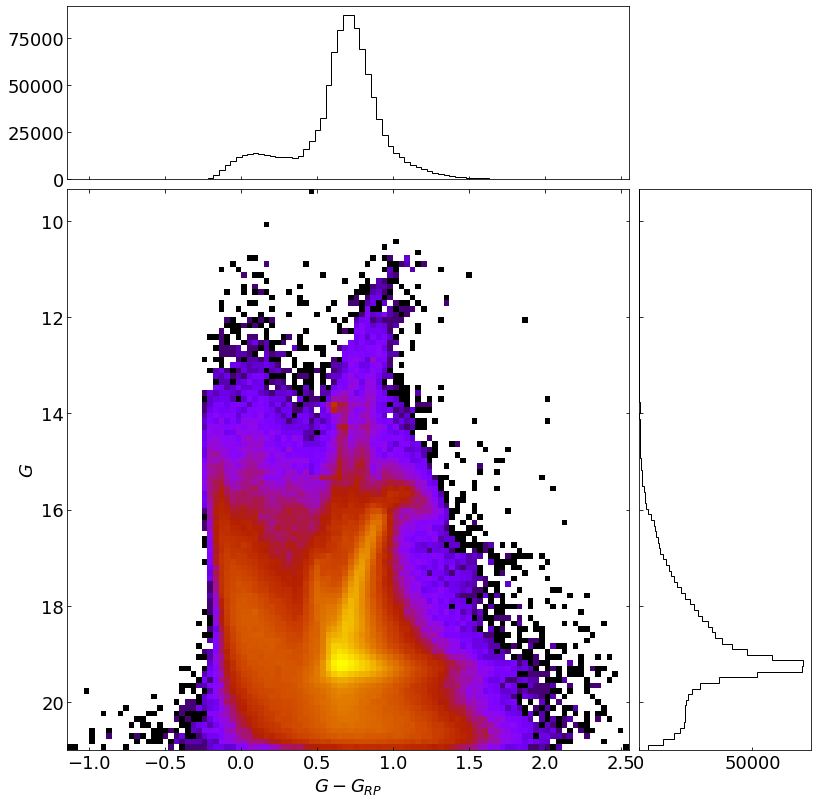

In [275]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.011

rect_image = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(12, 12))

ax_image = plt.axes(rect_image)
ax_image.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False) 

# the image plot:
ax_image.imshow(np.log10(Nggrp.statistic.T),origin='lower',
           extent=[Nggrp.x_edge[0],Nggrp.x_edge[-1],Nggrp.y_edge[0],Nggrp.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
# ax_image.scatter(0.96,19.275,marker='*')
# ax_image.scatter(rc_gaia['g_rp'],rc_gaia['phot_g_mean_mag'],alpha=0.01,c='gray')
ax_image.invert_yaxis()
ax_image.set_xlabel(r'$G - G_{RP}$')
ax_image.set_ylabel(r'$G$')

bins = 100
ax_histx.hist(smc_gaia['g_rp'], bins=bins,histtype='step',color='k')
ax_histy.hist(smc_gaia['phot_g_mean_mag'], bins=bins,histtype='step',orientation='horizontal',color='k')
ax_histy.invert_yaxis()

ax_histx.set_xlim(ax_image.get_xlim())
ax_histy.set_ylim(ax_image.get_ylim())

plt.show()

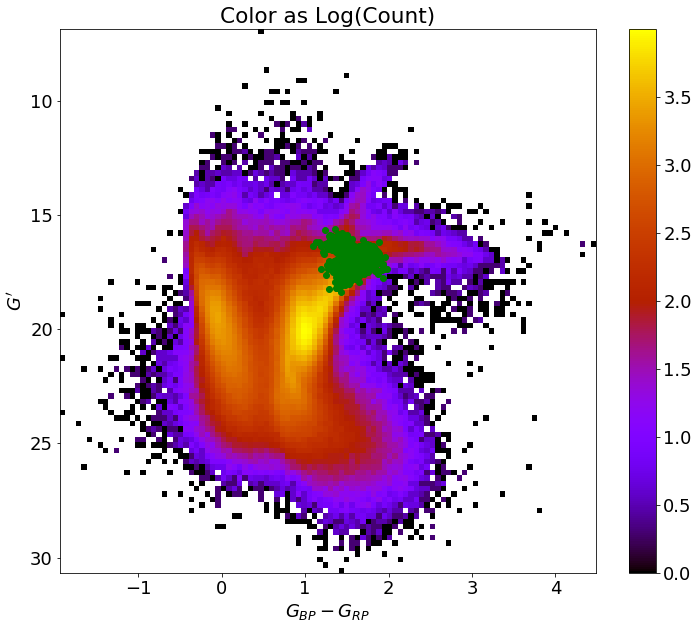

In [276]:
Gp = smc_gaia['phot_g_mean_mag'] + 5*np.log10(np.sqrt((smc_gaia['pmra'])**2+(smc_gaia['pmdec'])**2))
smc_Gp = smc['GAIA_GMAG'] + 5*np.log10(np.sqrt((smc['GAIA_PMRA'])**2+(smc['GAIA_PMDEC'])**2))

fin_Gp = np.where(np.isfinite(Gp)==True)

Np = binned_statistic_2d(x=smc_gaia[fin_Gp]['bp_rp'],y=Gp[fin_Gp],
                        values=smc_gaia[fin_Gp]['bp_rp'],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Np.statistic.T),origin='lower',
           extent=[Np.x_edge[0],Np.x_edge[-1],Np.y_edge[0],Np.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

plt.scatter(smc['GAIA_BPMAG']-smc['GAIA_RPMAG'],smc_Gp,c='green')

plt.gca().invert_yaxis()

plt.title(r'Color as Log(Count)')
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'$G^\prime$')
plt.savefig('reducedpmplot.pdf' )
plt.show()

Text(0, 0.5, '$G^\\prime$')

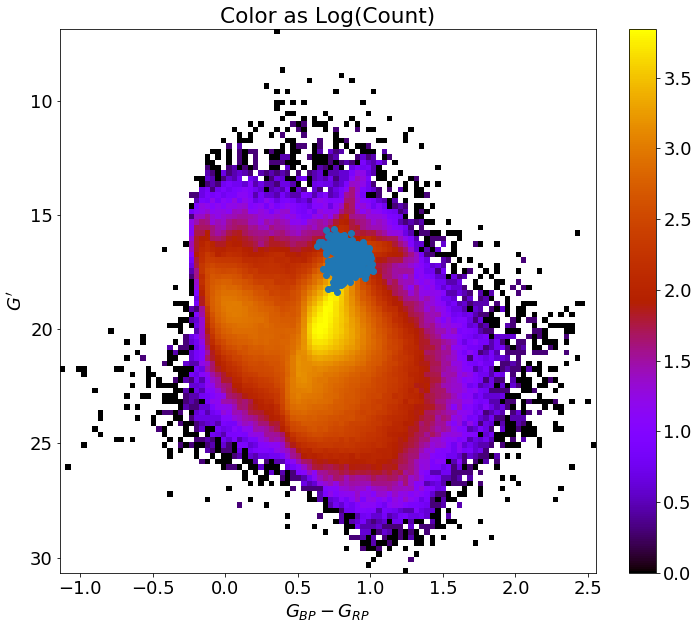

In [277]:
Gp = smc_gaia['phot_g_mean_mag'] + 5*np.log10(np.sqrt((smc_gaia['pmra'])**2+(smc_gaia['pmdec'])**2))
smc_Gp = smc['GAIA_GMAG'] + 5*np.log10(np.sqrt((smc['GAIA_PMRA'])**2+(smc['GAIA_PMDEC'])**2))

fin_Gp = np.where(np.isfinite(Gp)==True)

Np = binned_statistic_2d(x=smc_gaia[fin_Gp]['g_rp'],y=Gp[fin_Gp],
                        values=smc_gaia[fin_Gp]['g_rp'],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Np.statistic.T),origin='lower',
           extent=[Np.x_edge[0],Np.x_edge[-1],Np.y_edge[0],Np.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

plt.scatter(smc['GAIA_GMAG']-smc['GAIA_RPMAG'],smc_Gp)

plt.gca().invert_yaxis()

plt.title(r'Color as Log(Count)')
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'$G^\prime$')

Text(0, 0.5, '$G$')

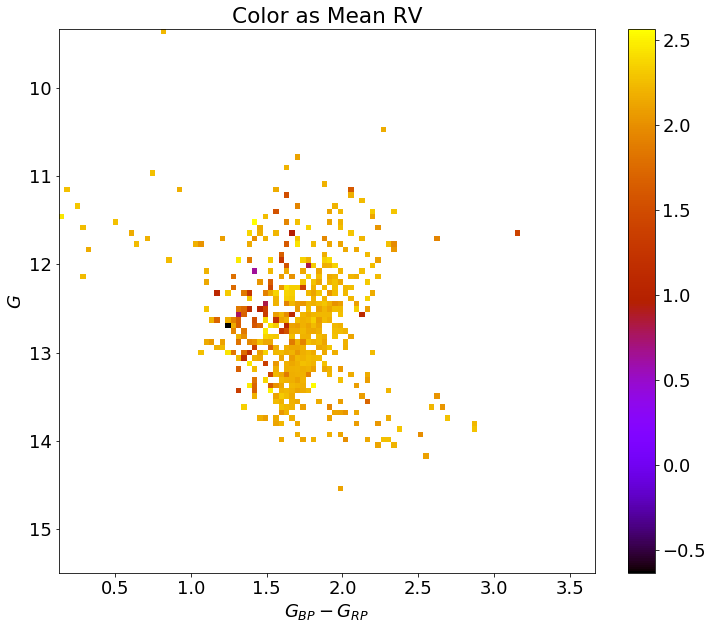

In [278]:
fin_rv = np.where(np.isfinite(smc_gaia['radial_velocity'])==True)

Nrv = binned_statistic_2d(x=smc_gaia[fin_rv]['bp_rp'],y=smc_gaia[fin_rv]['phot_g_mean_mag'],
                        values=smc_gaia[fin_rv]['radial_velocity'],statistic='mean',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Nrv.statistic.T),origin='lower',
           extent=[Nrv.x_edge[0],Nrv.x_edge[-1],Nrv.y_edge[0],Nrv.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

# plt.scatter(smc['GAIA_BPMAG']-smc['GAIA_RPMAG'],smc['GAIA_GMAG'])

plt.gca().invert_yaxis()

plt.title(r'Color as Mean RV')
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'$G$')

Text(0, 0.5, 'G')

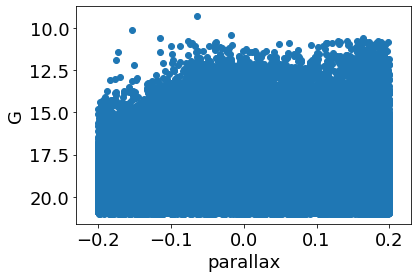

In [279]:
plt.scatter(smc_gaia['parallax'],smc_gaia['phot_g_mean_mag'])
plt.gca().invert_yaxis()

plt.xlabel('parallax')
plt.ylabel('G')

In [280]:
def circ_xy(x,y,x0,y0):
    dist = np.sqrt(np.subtract(x,x0)**2+np.subtract(y,y0)**2)
    return dist

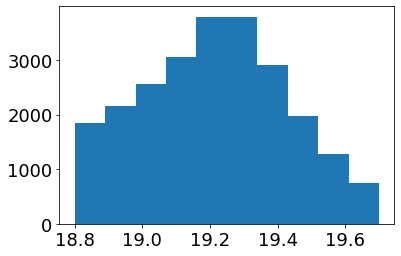

Mean G of RC:  19.21298


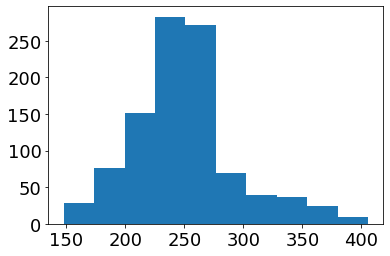

In [281]:
distfromcenter = circ_xy(rc_gaia['ra'],rc_gaia['dec'],13.18333333,-72.82833333)

rc_cen = rc_gaia[np.where(distfromcenter<=1.0)]

plt.hist(rc_cen['phot_g_mean_mag'])
plt.show()
print('Mean G of RC: ',np.mean(rc_cen['phot_g_mean_mag']))

dist_maybe = 60*(10**(-np.subtract(smc['GAIA_GMAG'],np.mean(rc_cen['phot_g_mean_mag']))/5))
plt.hist(dist_maybe)

plt.show()

1

(array([ 21., 177., 244., 261., 171.,  72.,  32.,  10.,   1.,   1.]),
 array([ 41.391541  ,  54.96289347,  68.53424595,  82.10559842,
         95.67695089, 109.24830336, 122.81965583, 136.3910083 ,
        149.96236077, 163.53371325, 177.10506572]),
 <a list of 10 Patch objects>)

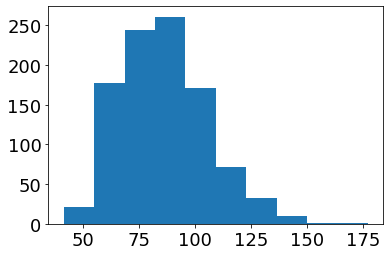

In [282]:
test = (61.7*np.nanmean(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2))/
        np.nanmean(smc['VHELIO_AVG'])*smc['VHELIO_AVG']/
        np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2))
plt.hist(test)

(-4, 4)

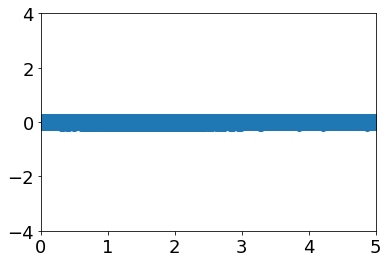

In [283]:
plt.scatter(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2),rc_gaia['parallax'])
# plt.scatter(rc_gaia['radial_velocity'],rc_gaia['parallax'])
plt.xlim(0,5)
plt.ylim(-4,4)

In [218]:
smc.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '36A'
    name = 'ASPCAP_ID'; format = '48A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '45A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '10A'
    name 

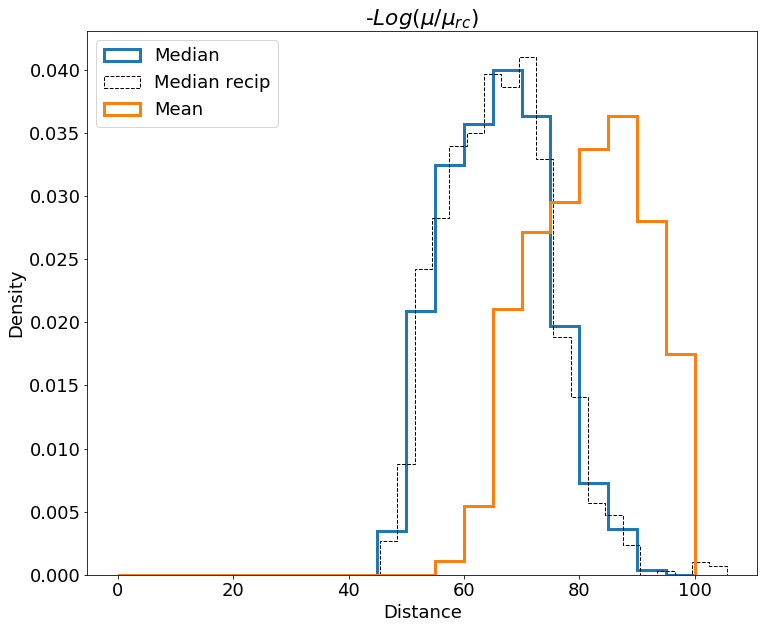

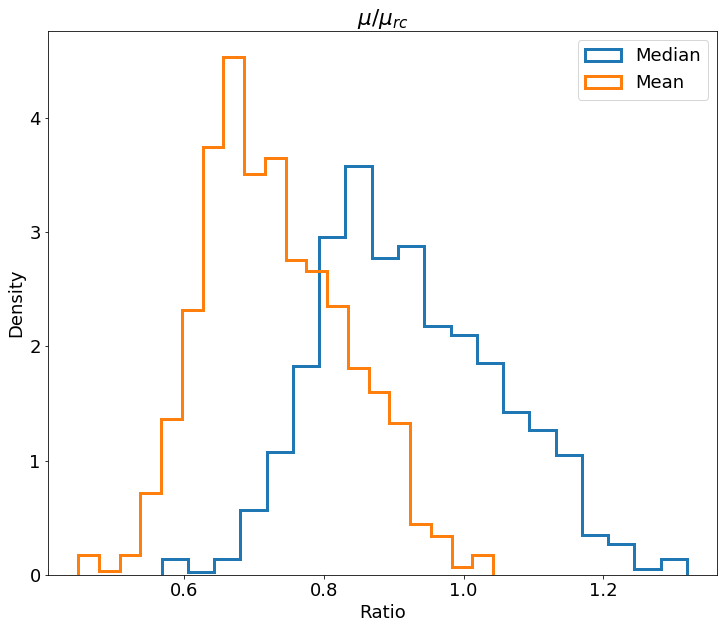

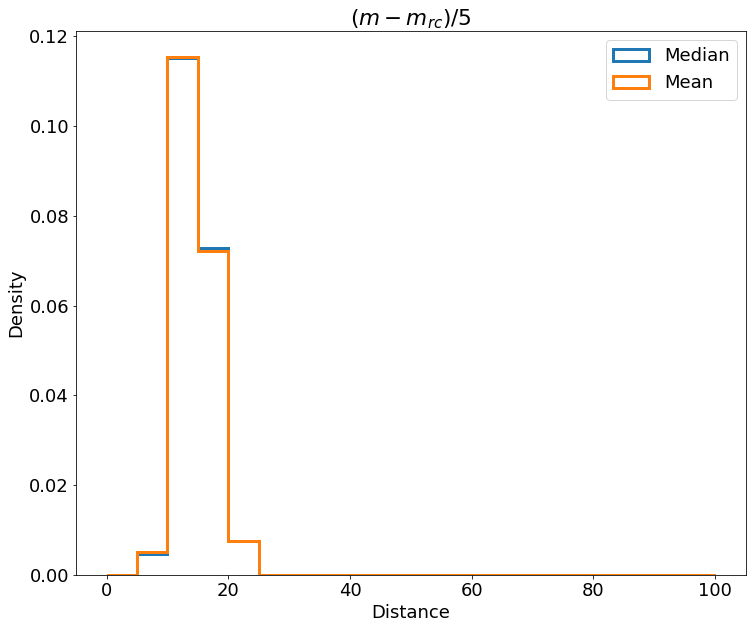

In [284]:
pmmag = np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)
rc_pmmag = np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2)

plt.figure(figsize=[12,10])
plt.hist(60*(10**(-np.log10(pmmag/np.nanmedian(rc_pmmag)))),
         range=(0,100),bins=20,density=True,histtype='step',label='Median',lw=3.0)
plt.hist(60*(np.nanmedian(rc_pmmag)/pmmag),
         bins=20,density=True,histtype='step',label='Median recip',color='k',ls='--')
plt.hist(60*(10**(-np.log10(pmmag/np.nanmean(rc_pmmag)))),
         range=(0,100),bins=20,density=True,histtype='step',label='Mean',lw=3.0)

plt.title(r'-$Log(\mu/\mu_{rc})$')
plt.xlabel(r'Distance')
plt.ylabel(r'Density')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=[12,10])
plt.hist(pmmag/np.nanmedian(rc_pmmag),bins=20,density=True,histtype='step',label='Median',lw='3.0')
plt.hist(pmmag/np.nanmean(rc_pmmag),bins=20,density=True,histtype='step',label='Mean',lw='3.0')

plt.title(r'$\mu/\mu_{rc}$')
plt.xlabel(r'Ratio')
plt.ylabel(r'Density')
plt.legend()
plt.show()


rc_g_mean = np.mean(rc_gaia['phot_g_mean_mag'])
rc_g_median = np.median(rc_gaia['phot_g_mean_mag'])

plt.figure(figsize=[12,10])
plt.hist(60*(10**(smc['GAIA_GMAG']/5-rc_g_mean/5)),
         range=(0,100),bins=20,density=True,histtype='step',label='Median',lw=3.0)
plt.hist(60*(10**(smc['GAIA_GMAG']/5-rc_g_median/5)),
         range=(0,100),bins=20,density=True,histtype='step',label='Mean',lw=3.0)

plt.title(r'$(m-m_{rc})/5$')
plt.xlabel(r'Distance')
plt.ylabel(r'Density')
plt.legend(loc='upper right')
plt.show()

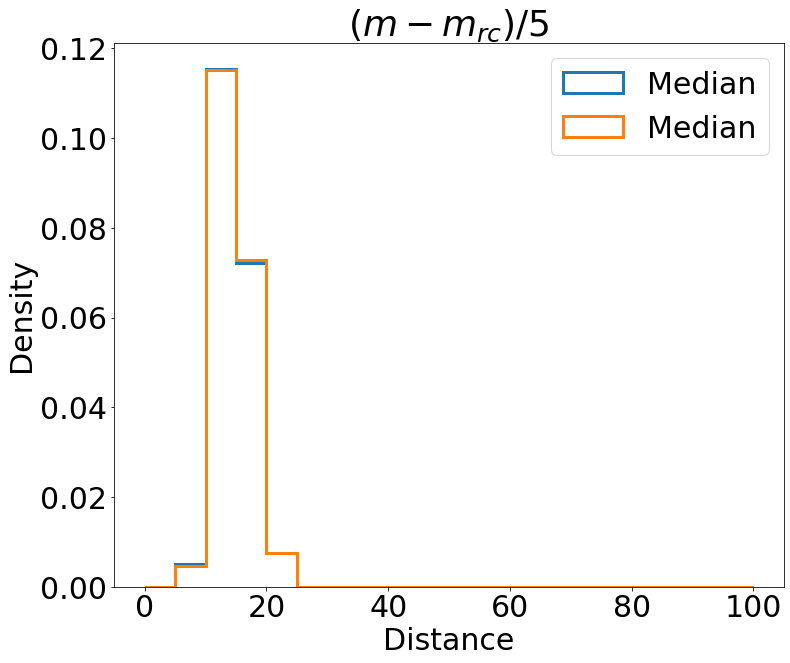

In [377]:
magdiff_med = 60*(10**((smc['GAIA_GMAG']-rc_g_median)/5))
magdiff_mea = 60*(10**((smc['GAIA_GMAG']-rc_g_mean)/5))

plt.figure(figsize=[12,10])
plt.hist(magdiff_med,range=(0,100),bins=20,density=True,histtype='step',label='Median',lw=3.0)
plt.hist(magdiff_mea,range=(0,100),bins=20,density=True,histtype='step',label='Median',lw=3.0)

# plt.hist(60*(10**(smc['GAIA_GMAG']/5-rc_g_mean/5)),
#          range=(0,100),bins=20,density=True,histtype='step',label='Median',lw=3.0)
# plt.hist(60*(10**(smc['GAIA_GMAG']/5-rc_g_median/5)),
#          range=(0,100),bins=20,density=True,histtype='step',label='Mean',lw=3.0)

plt.title(r'$(m-m_{rc})/5$')
plt.xlabel(r'Distance')
plt.ylabel(r'Density')
plt.legend(loc='upper right')
plt.show()

(array([  5.,  38., 111., 175., 219., 152., 137.,  90.,  40.,  23.]),
 array([0.5282973, 0.6205797, 0.7128622, 0.8051446, 0.8974271, 0.9897095,
        1.0819919, 1.1742743, 1.2665569, 1.3588393, 1.4511217],
       dtype=float32),
 <a list of 10 Patch objects>)

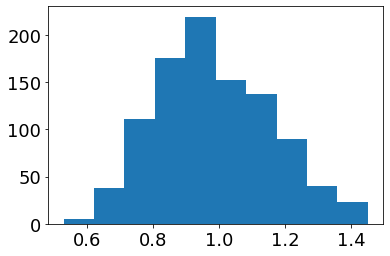

In [285]:
# plt.hist(np.reciprocal(smc['GAIA_PARALLAX']),range=(-100,100))
plt.hist(smc['VHELIO_AVG']/148)

<Figure size 864x720 with 0 Axes>

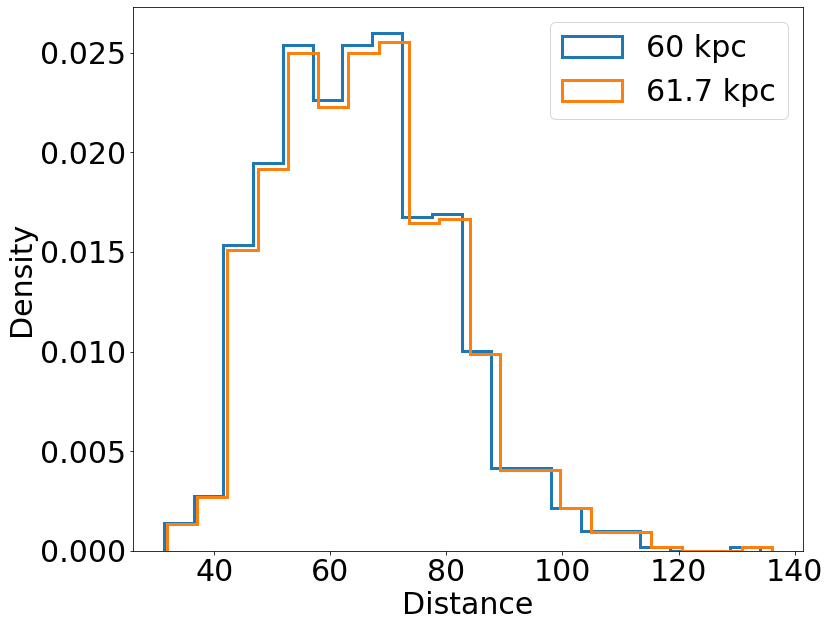

In [322]:
dist = 60*(np.nanmedian(rc_pmmag)/pmmag)*(smc['VHELIO_AVG']/148)
# dista = smc['VHELIO_AVG']/(4.74*(pmmag/1000))
dist617 = 61*(np.nanmedian(rc_pmmag)/pmmag)*(smc['VHELIO_AVG']/148)
# disthatz = 0.125*smc['VHELIO_AVG']

plt.figure(figsize=[12,10])
# plt.hist(60*(10**(-np.log10(pmmag/np.nanmedian(rc_pmmag)))),
#          range=(0,100),bins=20,density=True,histtype='step',label='Median',lw=3.0)
# plt.hist(60*(np.nanmedian(rc_pmmag)/pmmag),
#          bins=20,density=True,histtype='step',label='Median recip',color='k',ls='--')
# plt.hist(60*(10**(-np.log10(pmmag/np.nanmean(rc_pmmag)))),
#          range=(0,100),bins=20,density=True,histtype='step',label='Mean',lw=3.0)

plt.figure(figsize=[12,10])
plt.hist(dist,bins=20,density=True,histtype='step',lw=3.0,label='60 kpc')
plt.hist(dist617,bins=20,density=True,histtype='step',lw=3.0,label='61.7 kpc')
# plt.hist(disthatz,bins=20,density=True,histtype='step',lw=3.0,label='Hatz')
# plt.hist(dista,bins=20,density=True,histtype='step',color='k',lw=3.0,ls='--',label='No RC')

# plt.title(r'-$Log(\mu/\mu_{rc})$')
plt.xlabel(r'Distance')
plt.ylabel(r'Density')
plt.legend(loc='upper right')
plt.show()

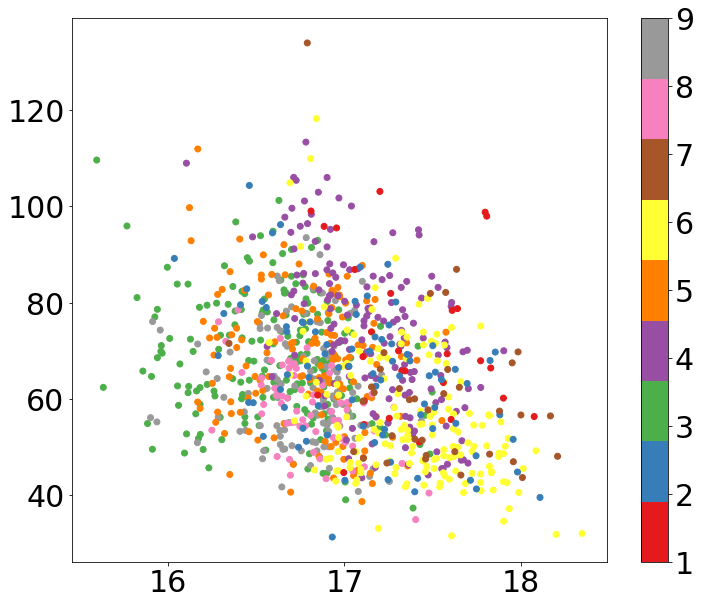

Text(0, 0.5, 'Density')

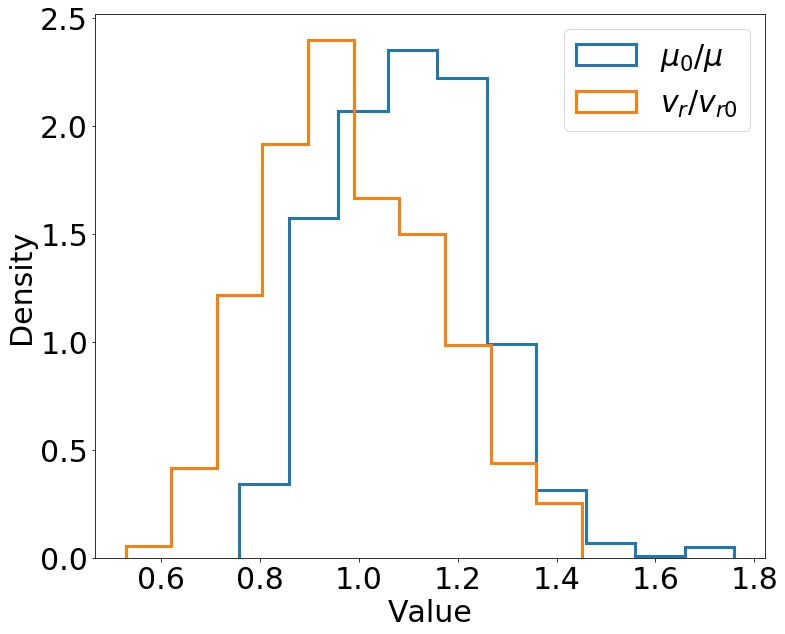

In [315]:
plt.figure(figsize=[12,10])
plt.hist(np.nanmedian(rc_pmmag)/pmmag,density=True,histtype='step',lw=3.0,label=r'$\mu_{0}/\mu$')
plt.hist((smc['VHELIO_AVG']/148),density=True,histtype='step',lw=3.0,label=r'$v_{r}/v_{r0}$')
plt.legend()

plt.xlabel(r'Value')
plt.ylabel(r'Density')

In [265]:
1/(60-12)

0.020833333333333332

In [257]:
np.max(dist)

136.79215015037806

In [31]:
np.nanmedian(60*(10**(np.log10(rc_pmmag)/5)))

66.19370681308314

In [197]:
4.74*60*np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2)

array([ 712.75386146,  345.82570829,  349.17696652, ..., 1106.52421638,
        379.86993044,  427.33873523])

Median:  71.35204844579582
Mean:  71.14759565678942


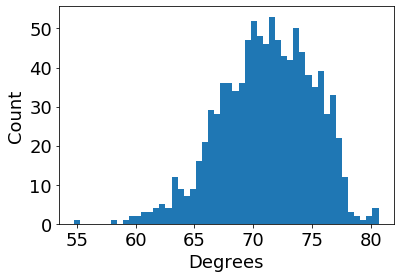

In [287]:
plt.hist(np.degrees(np.arctan(4.74*61.7*np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)/smc['VHELIO_AVG'])),
         bins=50)
plt.xlabel(r'Degrees')
plt.ylabel(r'Count')
print('Median: ',np.median(np.degrees(np.arctan(4.74*61.7*np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)/
                                                smc['VHELIO_AVG']))))
print('Mean: ',np.mean(np.degrees(np.arctan(4.74*61.7*np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)/
                                            smc['VHELIO_AVG']))))

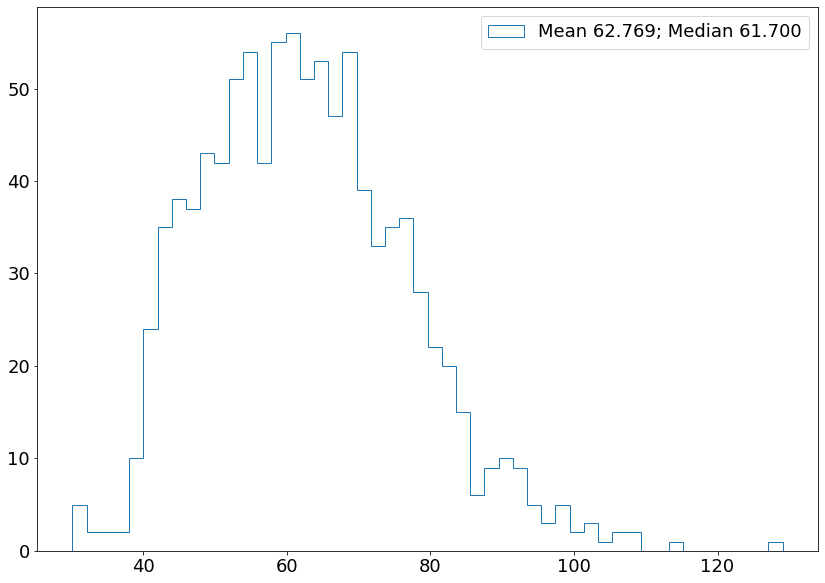

In [288]:
dist_2_stars = (smc['VHELIO_AVG']*np.tan(np.radians(71.35204844579582))/
          (4.74*np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)/1000))/1000
plt.figure(figsize=[14,10])
plt.hist(dist_2_stars,histtype='step',
         label='Mean {:.3f}; Median {:.3f}'.format(np.mean(dist_2_stars),np.median(dist_2_stars)),bins=50)
# plt.hist((smc['VHELIO_AVG']*np.tan(np.radians(70.86165237602208))/
#           (4.74*np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)/1000))/1000,histtype='step',
#          label='Median Angle {}'.format())
plt.legend()

(array([ 20.,  49., 117., 105., 301., 202., 113.,   0.,  42.,  41.]),
 array([-77.832718 , -76.7370202, -75.6413224, -74.5456246, -73.4499268,
        -72.354229 , -71.2585312, -70.1628334, -69.0671356, -67.9714378,
        -66.87574  ]),
 <a list of 10 Patch objects>)

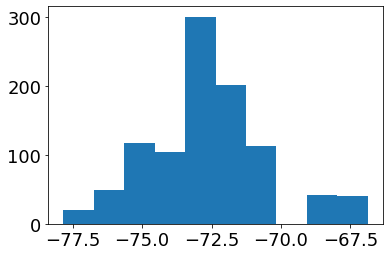

In [289]:
plt.hist(smc['DEC'])

In [290]:
np.mean((smc['VHELIO_AVG']*np.tan(np.radians(70.65751551334417))/
          (4.74*np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)/1000))/1000)

60.34474841528095

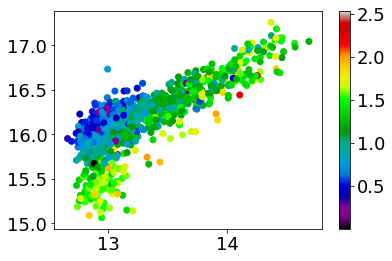

In [291]:
gravcut = np.where((smc['LOGG']>0.0)&(smc['LOGG']<2.5))
plt.scatter(smc['K'][gravcut],smc['GAIA_GMAG'][gravcut],c=smc['LOGG'][gravcut],cmap='nipy_spectral',
            vmax=max(smc['LOGG']),vmin=min(smc['LOGG']))
plt.colorbar()

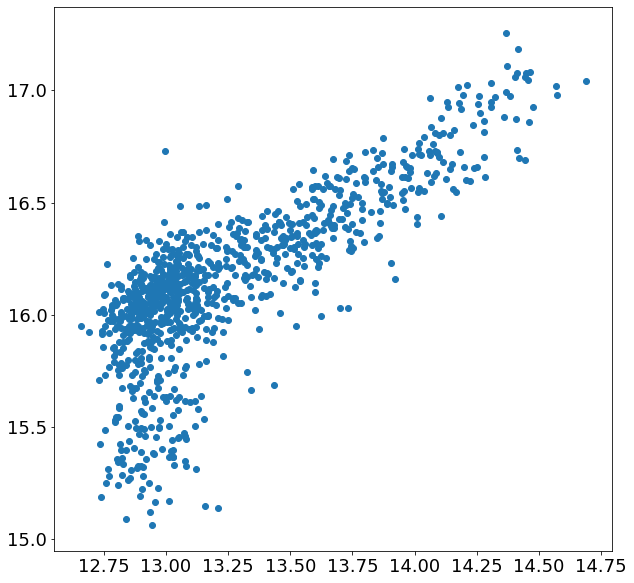

In [292]:
plt.figure(figsize=[10,10])
plt.scatter(smc['K'],smc['GAIA_GMAG'])

In [293]:
## Find Bloop
bloop = np.where((smc['H']<=13.25)&(smc['J']-smc['K']<=0.95)&(smc['TEFF']>=4175))
bloop_cut = []
for i in range(len(smc)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
smc_nobloop = smc[bloop_cut]

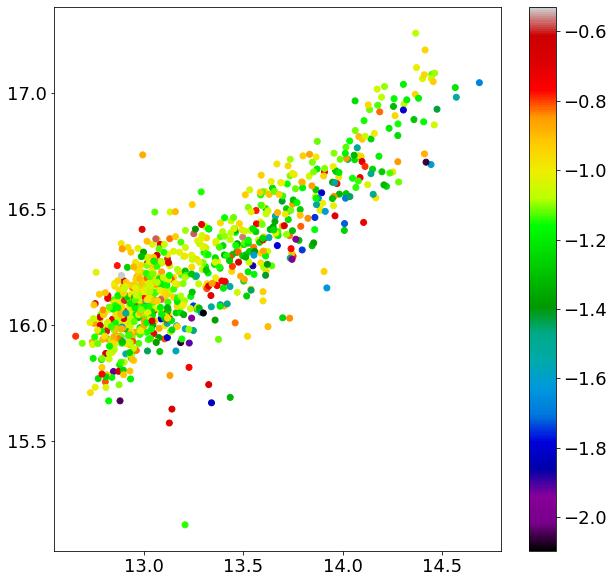

In [294]:
plt.figure(figsize=[10,10])
plt.scatter(smc_nobloop['K'],smc_nobloop['GAIA_GMAG'],c=smc_nobloop['FE_H'],cmap='nipy_spectral')
plt.colorbar()

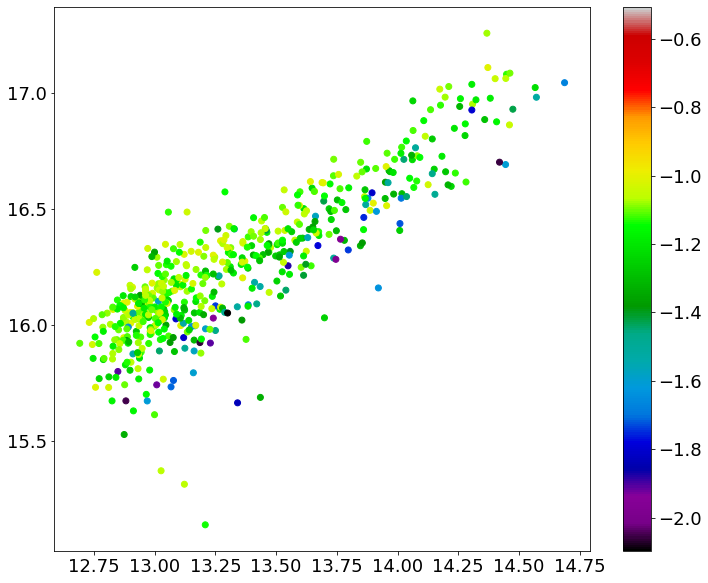

In [295]:

fehcut = np.where(smc['FE_H']<-1.0)
plt.figure(figsize=[12,10])
plt.scatter(smc['K'][fehcut],smc['GAIA_GMAG'][fehcut],c=smc['FE_H'][fehcut],cmap='nipy_spectral',
            vmax=max(smc['FE_H']),vmin=min(smc['FE_H']))
plt.colorbar()

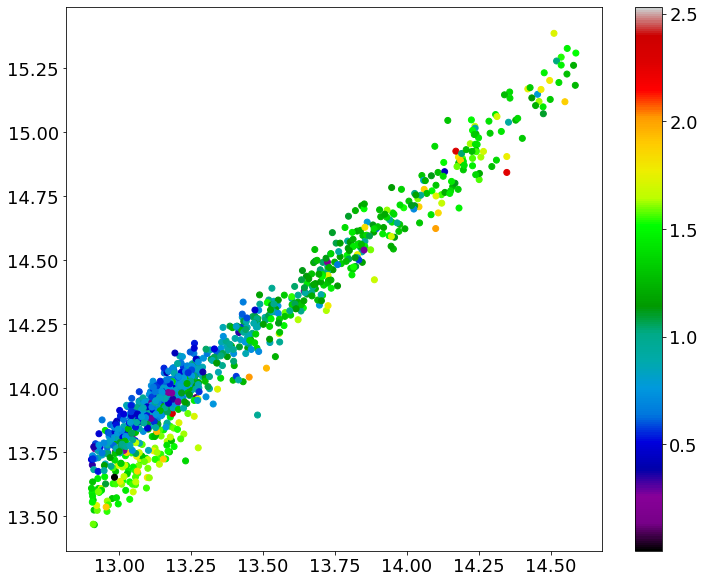

In [296]:
plt.figure(figsize=[12,10])
plt.scatter(smc['H'][gravcut],smc['J'][gravcut],c=smc['LOGG'][gravcut],cmap='nipy_spectral',
            vmax=max(smc['LOGG']),vmin=min(smc['LOGG']))
plt.colorbar()

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  2.,  2.,  1.,  5.,  2.,
        12.,  5.,  6., 11., 12., 16., 20., 13., 13.,  9.,  7.,  9.,  3.,
         4.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.00491841, 0.07056153, 0.13620465, 0.20184776, 0.2674909 ,
        0.333134  , 0.39877713, 0.46442023, 0.53006333, 0.59570646,
        0.6613496 , 0.7269927 , 0.7926358 , 0.85827893, 0.92392206,
        0.9895652 , 1.0552083 , 1.1208514 , 1.1864946 , 1.2521377 ,
        1.3177807 , 1.3834239 , 1.449067  , 1.5147101 , 1.5803533 ,
        1.6459963 , 1.7116395 , 1.7772826 , 1.8429257 , 1.9085689 ,
        1.9742119 , 2.039855  , 2.105498  , 2.1711414 , 2.2367845 ,
        2.3024275 ], dtype=float32),
 <a list of 35 Patch objects>)

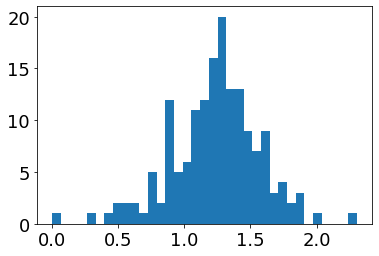

In [297]:
f6 = np.where(smc['FIELD']=='SMC6')
plt.hist(smc[f6]['LOGG'],bins=35)

In [256]:
smc.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '36A'
    name = 'ASPCAP_ID'; format = '48A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '45A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '10A'
    name 

# Magnitude Difference

In [277]:
rc_gaia.columns

ColDefs(
    name = 'solution_id'; format = 'K'
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'
    name = 'random_index'; format = 'K'
    name = 'ref_epoch'; format = 'D'; unit = 'yr'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = 'mas'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = 'mas'
    name = 'parallax'; format = 'D'; unit = 'mas'
    name = 'parallax_error'; format = 'D'; unit = 'mas'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmra_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra_corr'; format = 'E'
    name = 'ra_pmdec_corr'; format = 'E'
    name = 'dec_parallax_corr'; format = 'E'
    na

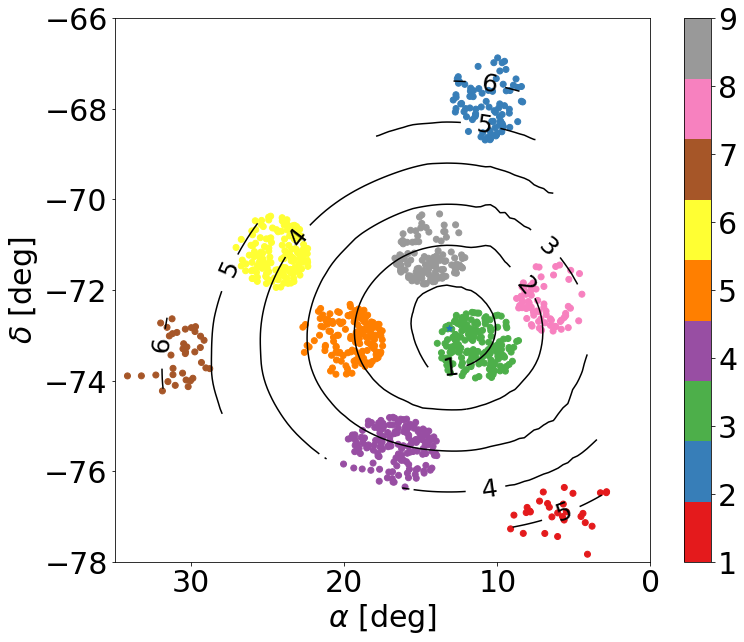

In [298]:
################
### SMC Map ###
###############

### Map

from scipy.interpolate import griddata

radius = smc['SMCRAD']*1.05

xx,yy = np.meshgrid(np.linspace(np.min(smc['RA']),np.max(smc['RA']),100),
                    np.linspace(np.min(smc['DEC']),np.max(smc['DEC']),100))

points = np.array([smc['RA'],smc['DEC']]).T

grid_z0 = griddata(points, radius, (xx, yy), method='cubic')

field_color = []
for i in range(len(smc)):
    if smc['FIELD'][i] == '47TUC':
        field_color.append(8.0)
    if smc['FIELD'][i] == 'N362':
        field_color.append(9.0)
    if smc['FIELD'][i] == 'SMC1':
        field_color.append(1.0)
    if smc['FIELD'][i] == 'SMC2':
        field_color.append(2.0)
    if smc['FIELD'][i] == 'SMC3':
        field_color.append(3.0)
    if smc['FIELD'][i] == 'SMC4':
        field_color.append(4.0)
    if smc['FIELD'][i] == 'SMC5':
        field_color.append(5.0)
    if smc['FIELD'][i] == 'SMC6':
        field_color.append(6.0)
    if smc['FIELD'][i] == 'SMC7':
        field_color.append(7.0)

matplotlib.rcParams.update({'font.size': 30})
# plt.figure(figsize=[12,12])

fig, ax = plt.subplots(figsize=[12,10])

plt.scatter(smc['RA'],smc['DEC'],c=field_color,cmap='Set1')
plt.colorbar()

plt.scatter(13.18333333,-72.82833333,marker='*')

plt.xlim(0,35)
plt.ylim(-78,-66)

plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

CS = plt.contour(xx,yy,grid_z0*1.05,levels=[1,2,3,4,5,6],colors='k')
plt.clabel(CS,fmt='%2.1d',colors='k',fontsize=25)#,manual=locations)

# plt.xticks([-8,-4.0,0,4.0,8])
# plt.yticks([-8,-4.0,0,4.0,8])

plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

# plt.savefig('SmcGeometry.pdf',bbox_inches='tight')
plt.show()

In [359]:
smc.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '36A'
    name = 'ASPCAP_ID'; format = '48A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '45A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '10A'
    name 

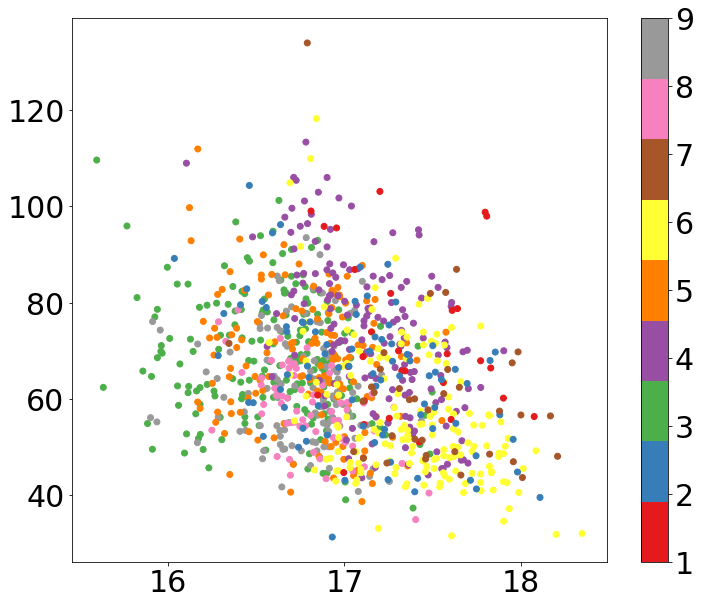

In [369]:
plt.figure(figsize=[12,10])
plt.scatter(smc_Gp,dist,c=field_color,cmap='Set1')
# plt.scatter(smc['J']-smc['K'],dist,c=dist,cmap='Set1')
plt.colorbar()

(array([1.33000e+02, 3.75000e+02, 7.97000e+02, 1.55800e+03, 3.34500e+03,
        8.79100e+03, 2.80050e+04, 1.03906e+05, 1.34409e+05, 2.79300e+04]),
 array([ 0.92968031,  9.76350585, 18.59733138, 27.43115691, 36.26498245,
        45.09880798, 53.93263351, 62.76645904, 71.60028458, 80.43411011,
        89.26793564]),
 <a list of 10 Patch objects>)

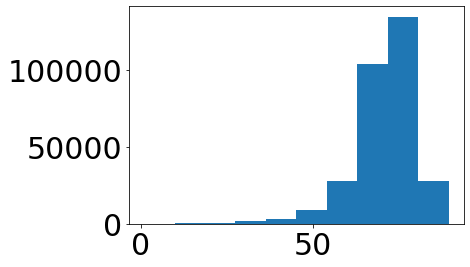

In [374]:
plt.hist(np.degrees(np.arctan((4.74*rc_pmmag*60)/148)))

In [375]:
np.tan(np.radians(90))

1.633123935319537e+16

(array([  0.,   0.,   0.,   0.,   0., 990.,   0.,   0.,   0.,   0.]),
 array([-10000.49 , -10000.391, -10000.29 , -10000.19 , -10000.09 ,
         -9999.99 ,  -9999.891,  -9999.79 ,  -9999.69 ,  -9999.59 ,
         -9999.49 ], dtype=float32),
 <a list of 10 Patch objects>)

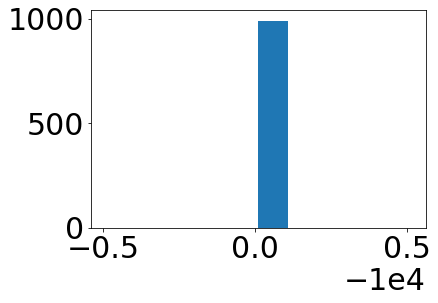

In [353]:
plt.hist(smc['VSINI'])

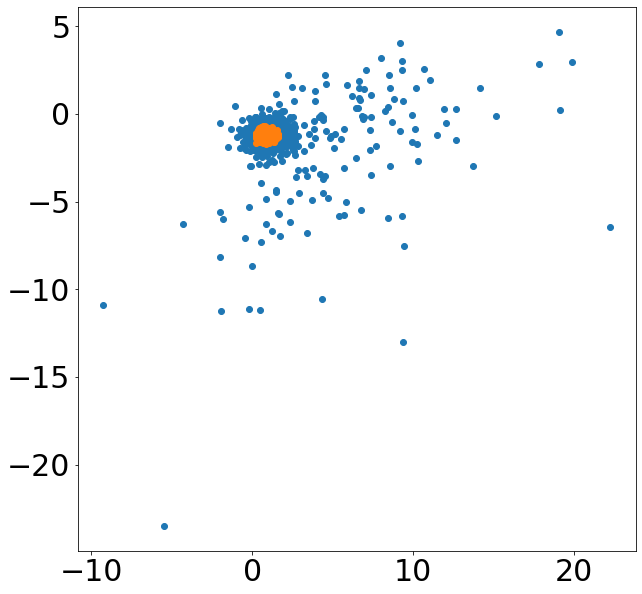

In [299]:
east = smc[np.where(smc['FIELD']=='SMC6')]
cent6 = [np.median(east['RA']),np.median(east['DEC'])]

def circ_xy(x,y,x0,y0):
    dist = np.sqrt(np.subtract(x,x0)**2+np.subtract(y,y0)**2)
    return dist

gaiax = circ_xy(rc_gaia['ra'],rc_gaia['dec'],cent6[0],cent6[1])

rc_gaia_6 = rc_gaia[np.where(gaiax<=1.0)]

plt.figure(figsize=[10,10])
plt.scatter(rc_gaia_6['pmra'],rc_gaia_6['pmdec'])
plt.scatter(smc['GAIA_PMRA'],smc['GAIA_PMDEC'])
plt.show()

In [300]:
distcen = np.asarray(np.sqrt((rc_gaia['ra']-13.18333333)**2+(rc_gaia['dec']-(-72.82833333))**2))
censtar = rc_gaia[distcen.argmin()]

censtar['phot_g_mean_mag']

19.62475

In [177]:
rc_gaia.columns

ColDefs(
    name = 'solution_id'; format = 'K'
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'
    name = 'random_index'; format = 'K'
    name = 'ref_epoch'; format = 'D'; unit = 'yr'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = 'mas'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = 'mas'
    name = 'parallax'; format = 'D'; unit = 'mas'
    name = 'parallax_error'; format = 'D'; unit = 'mas'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmra_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra_corr'; format = 'E'
    name = 'ra_pmdec_corr'; format = 'E'
    name = 'dec_parallax_corr'; format = 'E'
    na

In [173]:
smc.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '36A'
    name = 'ASPCAP_ID'; format = '48A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '45A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '10A'
    name 

Text(0, 0.5, '-Log($\\mu$)')

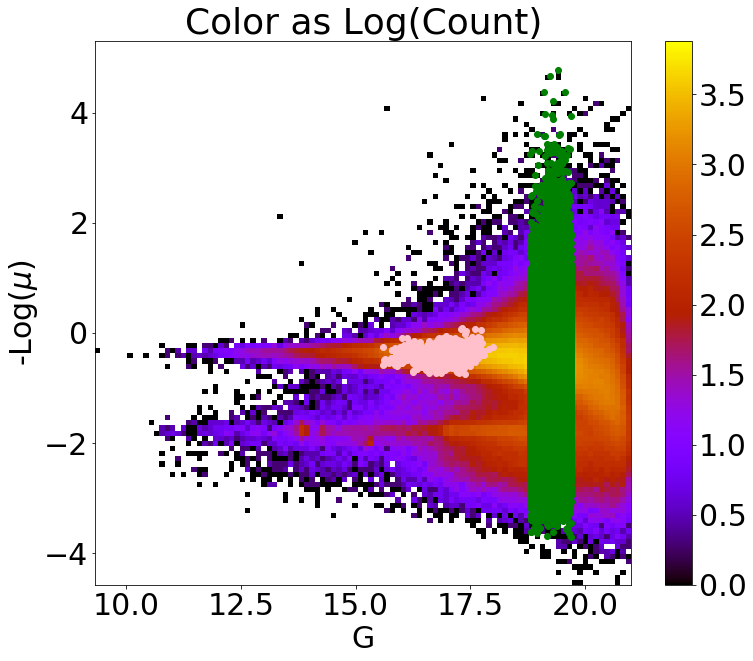

In [301]:
fin = np.where((np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(-np.log(np.sqrt((smc_gaia['pmra'])**2+(smc_gaia['pmdec'])**2)))==True))

Ngmu = binned_statistic_2d(x=smc_gaia['phot_g_mean_mag'][fin],
                          y=-np.log(np.sqrt((smc_gaia['pmra'])**2+(smc_gaia['pmdec'])**2))[fin],
                          values=smc_gaia['phot_g_mean_mag'][fin],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Ngmu.statistic.T),origin='lower',
           extent=[Ngmu.x_edge[0],Ngmu.x_edge[-1],Ngmu.y_edge[0],Ngmu.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

plt.scatter(smc['GAIA_BPMAG'],-np.log(np.sqrt((smc['GAIA_PMRA'])**2+(smc['GAIA_PMDEC'])**2)),c='pink')
plt.scatter(rc_gaia['phot_g_mean_mag'],-np.log(np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2)),c='green')

# plt.scatter(smc['GAIA_BPMAG']-smc['GAIA_RPMAG'],smc['GAIA_GMAG'])

# plt.gca().invert_yaxis()

plt.title(r'Color as Log(Count)')
plt.xlabel(r'G')
plt.ylabel(r'-Log($\mu$)')

# plt.figure(figsize=[12,10])
# plt.scatter(smc_gaia['phot_g_mean_mag'],-np.log(np.sqrt((smc_gaia['pmra'])**2+(smc_gaia['pmdec'])**2)))
# plt.scatter(smc['GAIA_BPMAG'],-np.log(np.sqrt((smc['GAIA_PMRA'])**2+(smc['GAIA_PMDEC'])**2)))
# plt.scatter(rc_gaia['phot_g_mean_mag'],-np.log(np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2)))

Text(0.5, 0, '-Log($\\mu$)')

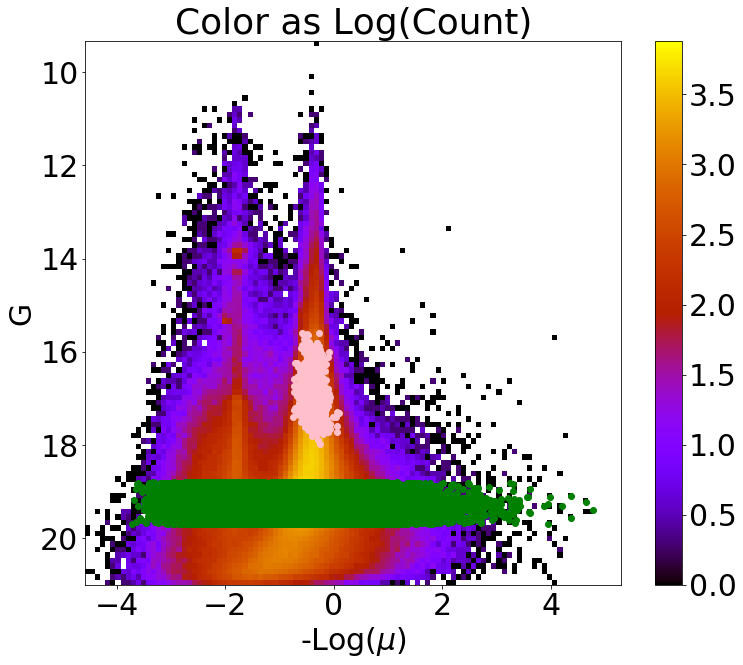

In [302]:
fin = np.where((np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(-np.log(np.sqrt((smc_gaia['pmra'])**2+(smc_gaia['pmdec'])**2)))==True))

Ngmu_r = binned_statistic_2d(x=-np.log(np.sqrt((smc_gaia['pmra'])**2+(smc_gaia['pmdec'])**2))[fin],
                             y=smc_gaia['phot_g_mean_mag'][fin],
                             values=smc_gaia['phot_g_mean_mag'][fin],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Ngmu_r.statistic.T),origin='lower',
           extent=[Ngmu_r.x_edge[0],Ngmu_r.x_edge[-1],Ngmu_r.y_edge[0],Ngmu_r.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

plt.scatter(-np.log(np.sqrt((smc['GAIA_PMRA'])**2+(smc['GAIA_PMDEC'])**2)),smc['GAIA_BPMAG'],c='pink')
plt.scatter(-np.log(np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2)),rc_gaia['phot_g_mean_mag'],c='green')

# plt.scatter(smc['GAIA_BPMAG']-smc['GAIA_RPMAG'],smc['GAIA_GMAG'])

plt.gca().invert_yaxis()

plt.title(r'Color as Log(Count)')
plt.ylabel(r'G')
plt.xlabel(r'-Log($\mu$)')

In [ ]:
60.*10**((-np.median())/5)

Text(0.5, 0, '-Log($\\mu$)')

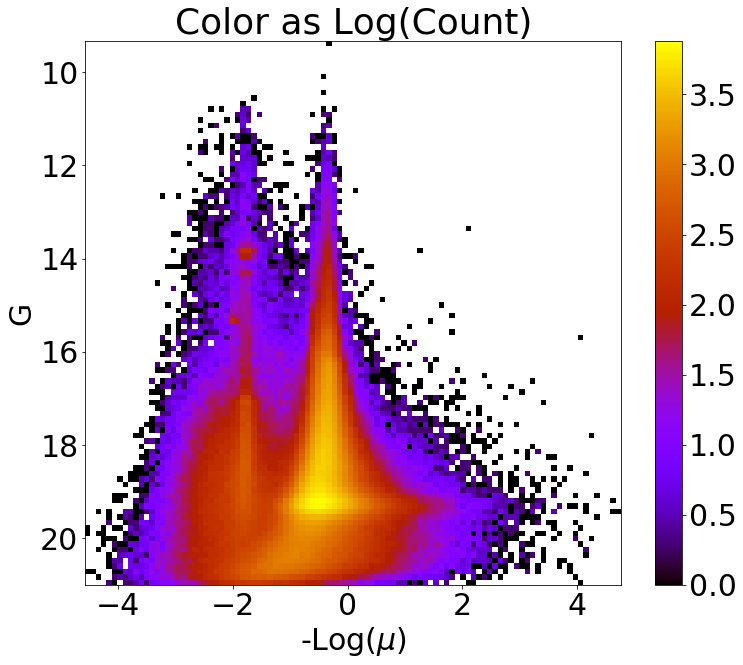

In [303]:
plt.figure(figsize=[12,10])
plt.imshow(np.log10(Ngmu_r.statistic.T),origin='lower',
           extent=[Ngmu_r.x_edge[0],Ngmu_r.x_edge[-1],Ngmu_r.y_edge[0],Ngmu_r.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

# plt.scatter(smc['GAIA_BPMAG']-smc['GAIA_RPMAG'],smc['GAIA_GMAG'])

plt.gca().invert_yaxis()

plt.title(r'Color as Log(Count)')
plt.ylabel(r'G')
plt.xlabel(r'-Log($\mu$)')

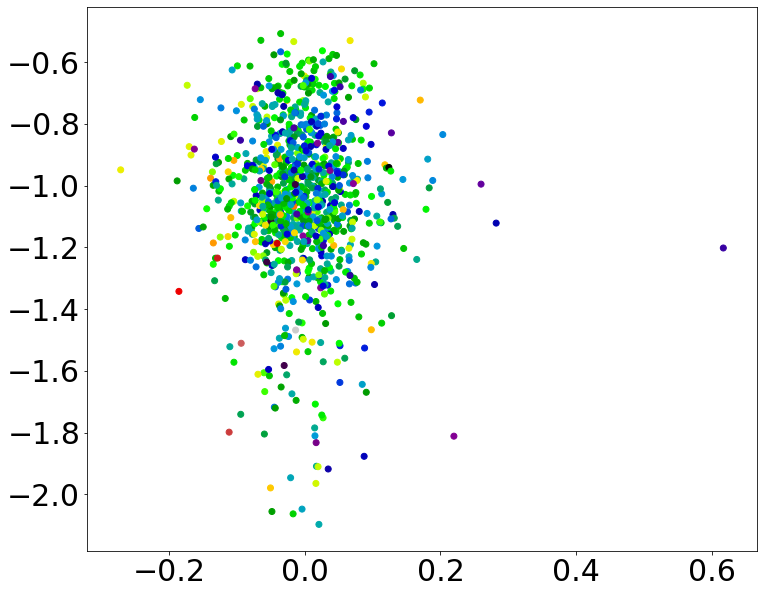

In [304]:

plt.figure(figsize=[12,10])
plt.scatter(smc['GAIA_PARALLAX'],smc['FE_H'],c=-np.log(np.sqrt((smc['GAIA_PMRA'])**2+(smc['GAIA_PMDEC'])**2)),
            cmap='nipy_spectral')

(array([ 47.,  67., 139., 352., 200.,  90.,  52.,  22.,  19.,   2.]),
 array([68.38384 , 69.84654 , 71.30924 , 72.77194 , 74.23464 , 75.69734 ,
        77.160034, 78.622734, 80.085434, 81.548134, 83.01083 ],
       dtype=float32),
 <a list of 10 Patch objects>)

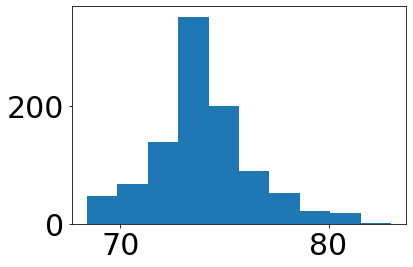

In [305]:
plt.hist(60*(10**((smc['GAIA_PHOT_G_MEAN_MAG']-19.33678)/5))+60)

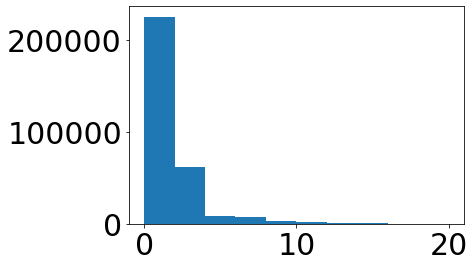

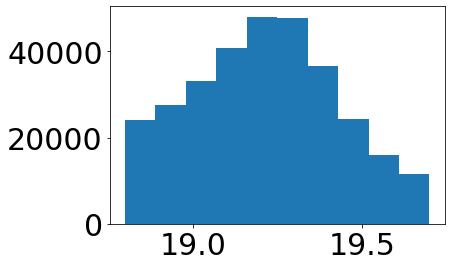

19.213259


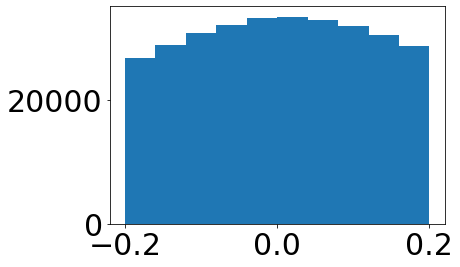

In [306]:
plt.hist(np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2),range=(0,20))
plt.show()

plt.hist(rc_gaia['phot_g_mean_mag'])
plt.show()
print(np.mean(rc_gaia['phot_g_mean_mag']))

plt.hist(rc_gaia['parallax'])
plt.show()

False

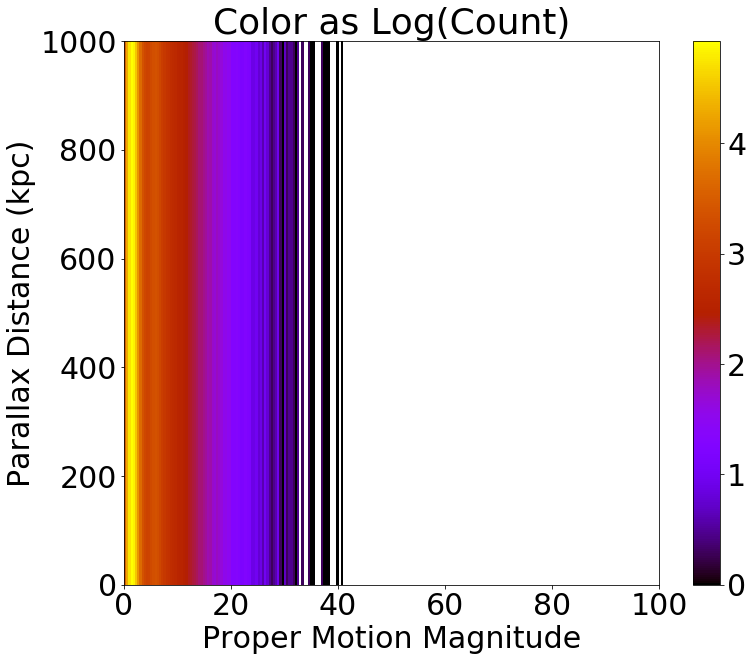

In [309]:
fin = np.where((np.isfinite(np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2))==True)&
               (np.isfinite(np.reciprocal(rc_gaia['parallax']))==True)) 

Npmg = binned_statistic_2d(x=np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2)[fin],
                           y=np.reciprocal(rc_gaia['parallax'])[fin],
                           values=np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2)[fin],
                           statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Npmg.statistic.T),origin='lower',
           extent=[Npmg.x_edge[0],Npmg.x_edge[-1],Npmg.y_edge[0],Npmg.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

# plt.scatter(smc['GAIA_GMAG']-smc['GAIA_RPMAG'],smc_Gp)

# plt.gca().invert_yaxis()

plt.ylim(0,1000)
plt.xlim(0,100)

plt.title(r'Color as Log(Count)')
plt.ylabel(r'Parallax Distance (kpc)')
plt.xlabel(r'Proper Motion Magnitude')
plt.show()


# plt.scatter(np.sqrt((rc_gaia['pmra'])**2+(rc_gaia['pmdec'])**2),np.reciprocal(rc_gaia['parallax']),
#             c=rc_gaia[''])
# plt.ylim(0,100)
# plt.xlim(0,10)

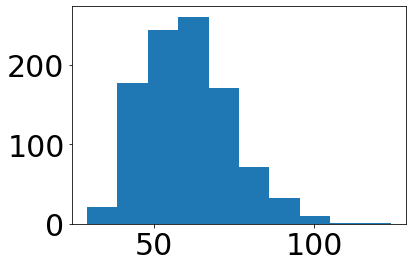

60.34474841528095


In [310]:

# phi = 70.65751551334417 deg
dist_maybe = (smc['VHELIO_AVG']*np.tan(np.radians(70.65751551334417))/
          (4.74*np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)/1000))/1000
plt.hist(dist_maybe)
plt.show()
print(np.mean(dist_maybe))

In [311]:
def dist_vel_pm(vel, phi, mu):
    return (np.multiply(vel,np.tan(phi))/(4.74*(mu/1000)))/1000

In [312]:
plt.hist(dist_vel_pm(smc['VHELIO_AVG'],np.sqrt(smc['GAIA_PMRA']**2+smc['GAIA_PMDEC']**2)))

TypeError: dist_vel_pm() missing 1 required positional argument: 'mu'

In [318]:
smc.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '36A'
    name = 'ASPCAP_ID'; format = '48A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '45A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '10A'
    name 

([array([  0.,   0.,   0.,   0.,   0., 990.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 990.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0., 990.,   0.,   0.,   0.,   0.])],
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5],
       dtype=float32),
 <a list of 3 Lists of Patches objects>)

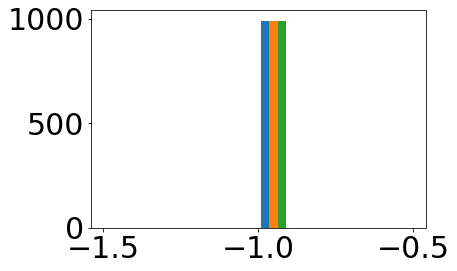

In [321]:
plt.hist(smc['DISO_GAL'])

(array([658839.]), array([-100,  500]), <a list of 1 Patch objects>)

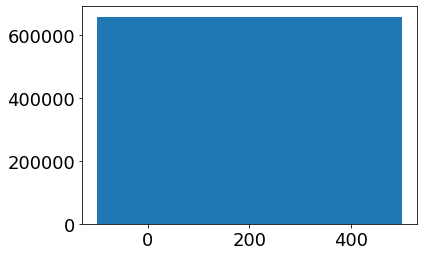

In [126]:
plt.hist(4.74*(rc_pmmag/1000)*(1/rc_gaia['parallax']),bins=(-100,500))

(array([2719., 2130., 1683., 1370., 1133.,  914.,  798.,  698.,  607.,
         550.]),
 array([ 40.,  46.,  52.,  58.,  64.,  70.,  76.,  82.,  88.,  94., 100.]),
 <a list of 10 Patch objects>)

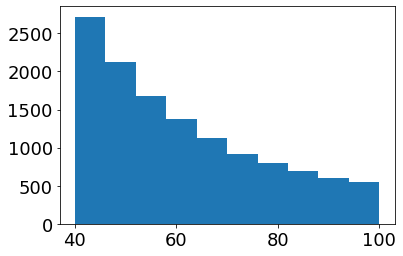

In [138]:
plt.hist((1/rc_gaia['parallax']),range=(40,100))

(40, 100)

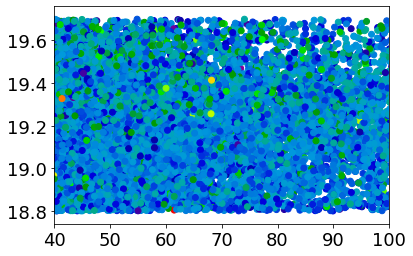

In [145]:
plt.scatter(np.reciprocal(rc_gaia['parallax']),rc_gaia['phot_g_mean_mag'],c=rc_gaia['g_rp'],cmap='nipy_spectral')
plt.xlim(40,100)